In [0]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, FloatType, DoubleType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler, Imputer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [0]:
# read data

file_location = "/FileStore/tables/LLCP2023.csv"
file_type = "csv"

infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df.show()

+--------+--------+--------+--------+------+--------+--------------------+--------------------+------+--------+-------+-------+-------+--------+--------+
|DIABETE4|_AGE65YR|_RFHYPE6|_RFCHOL3| _BMI5|_SMOKER3|            STRFREQ_|            _DRNKWK2|SEXVAR|MENTHLTH|_EDUCAG|INCOME3|EMPLOY1|_IMPRACE|FLUSHOT7|
+--------+--------+--------+--------+------+--------+--------------------+--------------------+------+--------+-------+-------+-------+--------+--------+
|     3.0|     2.0|     2.0|     1.0|2650.0|     4.0|              3000.0|5.397605346934028...|   1.0|     1.0|    4.0|    9.0|    7.0|     1.0|     2.0|
|     3.0|     1.0|     1.0|     2.0|3269.0|     4.0|              1000.0|5.397605346934028...|   2.0|    88.0|    4.0|   11.0|    1.0|     1.0|     2.0|
|     1.0|     1.0|     1.0|     1.0|2763.0|     1.0|              1000.0|               187.0|   2.0|    88.0|    2.0|    6.0|    5.0|     1.0|     2.0|
|     1.0|     2.0|     1.0|     1.0|2509.0|     4.0|              2000.0|5.

In [0]:
# diabetes - yes and no only/ age over 18 only
df = df.filter((F.col('DIABETE4').isin(1,3))&(F.col('_AGE65YR').isin(1,2)))

df = df.withColumn('is_diabetes', F.when(df.DIABETE4==1,'Y').otherwise('N'))
df = df.withColumn('high_blood_pressure', F.when(df._RFHYPE6==1,'N')
                                          .when(df._RFHYPE6==2,'Y')
                                          .otherwise(None))
df = df.withColumn('high_cholesterol', F.when(df._RFCHOL3==1,'N')
                                        .when(df._RFCHOL3==2,'Y')
                                        .otherwise(None))
df = df.withColumnRenamed('_BMI5','bmi')
df = df.withColumn('smoke', F.when(df._SMOKER3==1, 'everyday_smoker')
                              .when(df._SMOKER3==2, 'someday_smoke')
                              .when(df._SMOKER3==3, 'former_smoke')
                              .when(df._SMOKER3==4, 'never_smoked')
                              .otherwise(None))

# strength activity frequency
df = df.withColumn('exercise', F.when(df.STRFREQ_<99000, df.STRFREQ_).otherwise(None))

# number of drinks of alcohol per week
df = df.withColumn('alcohol', F.when(df._DRNKWK2<99900, df._DRNKWK2).otherwise(None))

df = df.withColumn('gender', F.when(df.SEXVAR==1,'M').otherwise('F'))

# number of days mental health not good
df = df.withColumn('mental_health', F.when(df.MENTHLTH<=30, df.MENTHLTH).when(df.MENTHLTH==88,0).otherwise(None))

# Education level
df = df.withColumn('edu',  F.when(df._EDUCAG==1, 'under_highschool')
                              .when(df._EDUCAG==2, 'highschool_grad')
                              .when(df._EDUCAG==3, 'attended_college')
                              .when(df._EDUCAG==4, 'college_grad')
                              .otherwise(None))

# Income level
df = df.withColumn('income', F.when(df.INCOME3<=11, df.INCOME3).otherwise(None))

# Work status
df = df.withColumn('work', F.when(df.EMPLOY1<=2,'working').when(df.EMPLOY1<=8,'not_working').otherwise(None))

# Race
df = df.withColumn('race',  F.when(df._IMPRACE==1, 'white')
                              .when(df._IMPRACE==2, 'black')
                              .when(df._IMPRACE==3, 'asian')
                              .when(df._IMPRACE==4, 'american_indian')
                              .when(df._IMPRACE==5, 'hispanic')
                              .otherwise('others'))

# Flu shot
df = df.withColumn('flushot', F.when(df.FLUSHOT7==1,'Y').when(df.FLUSHOT7==2,'N').otherwise(None))

df = df.select('is_diabetes','high_blood_pressure','high_cholesterol','bmi','smoke','exercise','alcohol','gender','mental_health','edu','income','work','race','flushot')

In [0]:
# check the number of null values for each columns
df.select([F.sum(df[i].isNull().cast(IntegerType())).alias(i) for i in df.columns]).show()

+-----------+-------------------+----------------+-----+-----+--------+-------+------+-------------+----+------+----+----+-------+
|is_diabetes|high_blood_pressure|high_cholesterol|  bmi|smoke|exercise|alcohol|gender|mental_health| edu|income|work|race|flushot|
+-----------+-------------------+----------------+-----+-----+--------+-------+------+-------------+----+------+----+----+-------+
|          0|               1444|           52215|35479|21054|   13192|  30131|     0|         7315|1469| 78739|6372|   0|  28718|
+-----------+-------------------+----------------+-----+-----+--------+-------+------+-------------+----+------+----+----+-------+



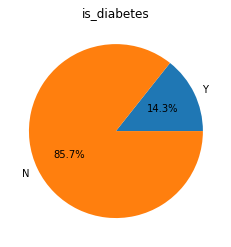

In [0]:
# check the proportion of each class in target variable
t = df.groupBy('is_diabetes').count().toPandas()
plt.pie(t['count'], labels=t['is_diabetes'], autopct='%1.1f%%')
plt.title('is_diabetes')
plt.show()

In [0]:
# seperate column names into numeric and categorical variables
numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]
cat_cols = list(set(df.columns) - set(numeric_cols))
cat_cols.remove('is_diabetes')
non_ohe_cols = cat_cols.copy()
non_ohe_cols.remove('race')
print(numeric_cols)
print(cat_cols)
print(non_ohe_cols) # use label-encoding not one-hot encoding

['bmi', 'exercise', 'alcohol', 'mental_health', 'income']
['work', 'race', 'gender', 'high_blood_pressure', 'edu', 'flushot', 'smoke', 'high_cholesterol']
['work', 'gender', 'high_blood_pressure', 'edu', 'flushot', 'smoke', 'high_cholesterol']


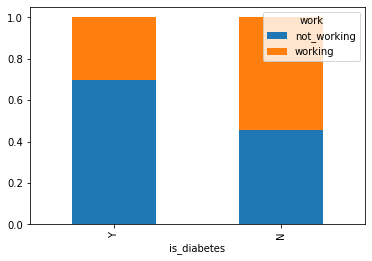

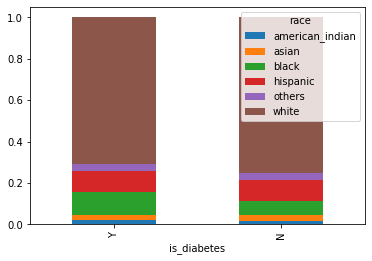

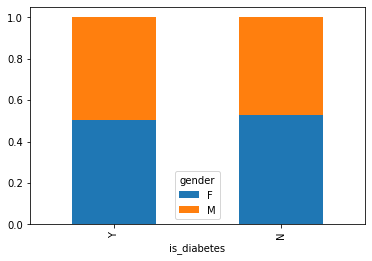

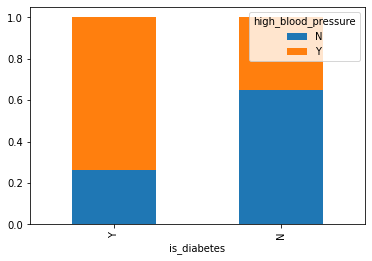

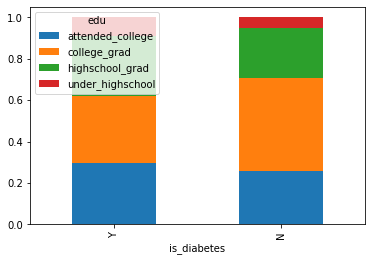

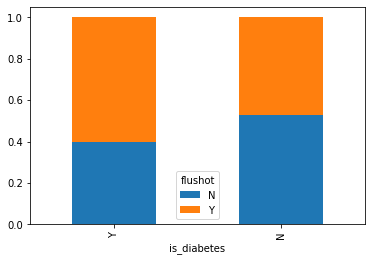

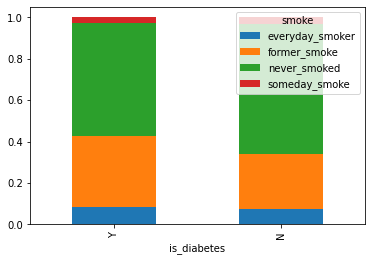

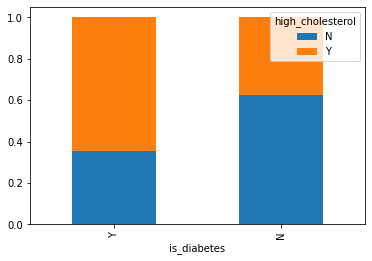

In [0]:
# draw bar plots of categorical variable proportions by diabetes

for i in cat_cols:
  temp = df.dropna(subset=i).crosstab(col1='is_diabetes', col2=i).withColumnRenamed('is_diabetes_'+i, 'is_diabetes')
  temp = temp.withColumn('total', sum([F.col(c) for c in temp.columns[1:]]))
  for j in temp.columns[1:-1]:
    temp = temp.withColumn(j, F.col(j)/F.col('total'))
  temp_pd = temp.toPandas().set_index('is_diabetes').drop('total', axis=1)
  temp_pd.columns.name = i # assign a name to the column axis itself
  temp_pd.plot(kind='bar', stacked=True)
  plt.show()

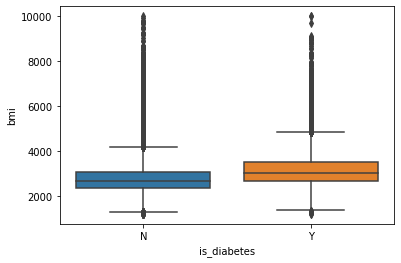

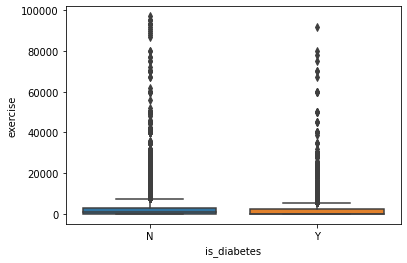

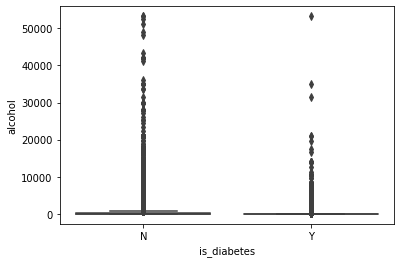

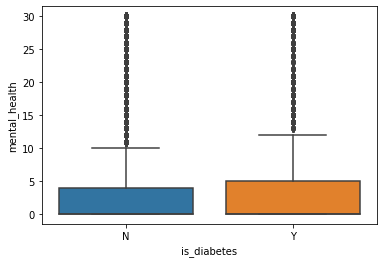

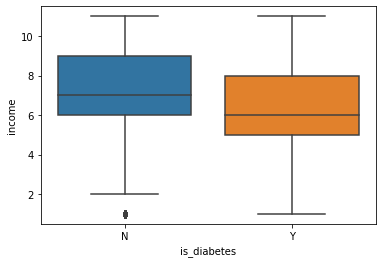

In [0]:
 # draw box plots of numerical variables by diabetes (using pandas dataframe)

df_pd = df.toPandas()

for i in numeric_cols:
  sns.boxplot(x='is_diabetes', y=i, data=df_pd)
  plt.show()

In [0]:
# check the number of null values for each columns
df.select([F.sum(df[i].isNull().cast(IntegerType())).alias(i) for i in df.columns]).show()

+-----------+-------------------+----------------+-----+-----+--------+-------+------+-------------+----+------+----+----+-------+
|is_diabetes|high_blood_pressure|high_cholesterol|  bmi|smoke|exercise|alcohol|gender|mental_health| edu|income|work|race|flushot|
+-----------+-------------------+----------------+-----+-----+--------+-------+------+-------------+----+------+----+----+-------+
|          0|               1444|           52215|35479|21054|   13192|  30131|     0|         7315|1469| 78739|6372|   0|  28718|
+-----------+-------------------+----------------+-----+-----+--------+-------+------+-------------+----+------+----+----+-------+



In [0]:
df = df.withColumn('null_cnt', sum(F.when(df[i].isNull(),1).otherwise(0) for i in df.columns))
df.groupBy('null_cnt').count().orderBy('null_cnt').show()

+--------+------+
|null_cnt| count|
+--------+------+
|       0|256599|
|       1| 96040|
|       2| 29702|
|       3| 11604|
|       4|  5929|
|       5|  6380|
|       6|  3762|
|       7|   943|
|       8|   108|
|       9|    22|
|      10|     1|
|      11|     1|
+--------+------+



In [0]:
# delete data having more than 1 null value
df = df.filter(df.null_cnt<2)
df = df.drop('null_cnt')
df.count()

Out[7]: 352639

In [0]:
# split data into train & test set through stratified sampling

train = df.sampleBy('is_diabetes', {'Y':.7, 'N':.7}, seed=111)
test = df.subtract(train)
print('-- train set --')
train.groupBy('is_diabetes').count().withColumn('prop', F.col('count')/train.count()).show()
print('\n-- test set --')
test.groupBy('is_diabetes').count().withColumn('prop', F.col('count')/test.count()).show()

-- train set --
+-----------+------+-------------------+
|is_diabetes| count|               prop|
+-----------+------+-------------------+
|          Y| 36159|0.14629912849270507|
|          N|210999| 0.8537008715072949|
+-----------+------+-------------------+


-- test set --
+-----------+-----+-------------------+
|is_diabetes|count|               prop|
+-----------+-----+-------------------+
|          Y|15331|0.14715735114848197|
|          N|88850| 0.8528426488515181|
+-----------+-----+-------------------+



In [0]:

# string indexer
idx_ls = StringIndexer(inputCols=cat_cols, outputCols=[i+'_idx' for i in cat_cols], handleInvalid='skip', stringOrderType='alphabetAsc')

# null imputation
imp_num = Imputer(inputCols=numeric_cols, outputCols=[i+'_imp' for i in numeric_cols], strategy='median')
imp_cat = Imputer(inputCols=[i+'_idx' for i in cat_cols], outputCols=[i+'_imp' for i in cat_cols], strategy='mode')

# One Hot Encoder
ohe = OneHotEncoder(inputCol='race_imp', outputCol='race_ohe')

# min max scaler
num_vec = VectorAssembler(inputCols=[i+'_imp' for i in numeric_cols], outputCol='num_vec')
scaler_ls = MinMaxScaler(inputCol='num_vec', outputCol='num_vec_scale')

assembler = VectorAssembler(inputCols=['num_vec_scale']+[i+'_imp' for i in non_ohe_cols]+['race_ohe'], outputCol='features')

# for label
idx_label = StringIndexer(inputCol='is_diabetes', outputCol='label')


pp_train = Pipeline(stages=[idx_ls, imp_num, imp_cat, ohe, num_vec, scaler_ls, assembler, idx_label])

# prep for features
train_final = pp_train.fit(train).transform(train)
test_final = pp_train.fit(train).transform(test) # fit train and transform test

In [0]:
# oversampling
print('-- original training set --')
train_final.groupBy('label').count().show()

minor_cnt = train_final.groupBy('label').count().orderBy(F.col('count')).first()['count']
major_cnt = train_final.groupBy('label').count().orderBy(F.col('count').desc()).first()['count']
minor_cat = train_final.groupBy('label').count().orderBy(F.col('count')).first()['label']
overSampleRatio = major_cnt / minor_cnt - 1
train_final_over = train_final.filter(train_final.label==minor_cat).sample(withReplacement=True, fraction=overSampleRatio, seed=111).union(train_final)
print('-- training set with oversampling --')
train_final_over.groupBy('label').count().show()

-- original training set --
+-----+------+
|label| count|
+-----+------+
|  0.0|187615|
|  1.0| 34585|
+-----+------+

-- training set with oversampling --
+-----+------+
|label| count|
+-----+------+
|  1.0|186982|
|  0.0|187615|
+-----+------+



In [0]:
### save files
# train_final_over.write.parquet('/FileStore/train_final_over.parquet', mode='overwrite')
# test_final.write.parquet('/FileStore/test_final.parquet', mode='overwrite')

In [0]:
train_final_over = spark.read.parquet('/FileStore/train_final_over.parquet', mode='overwrite')
test_final = spark.read.parquet('/FileStore/test_final.parquet', mode='overwrite')

In [0]:
# Logistic Regression
lr_model = LogisticRegression()

grid = (ParamGridBuilder()
        .addGrid(lr_model.regParam, [0.0, .2, .4, .6, .8, 1.0])
        .addGrid(lr_model.elasticNetParam, [0.0, .3, .6, 1.0])
        .build())
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

cv = CrossValidator(estimator=lr_model, estimatorParamMaps=grid, evaluator=evaluator)

lr_cv = cv.fit(train_final_over)

In [0]:
print("-- Parameters used for the best model --")
print('regParam : ', lr_cv.bestModel.extractParamMap()[lr_cv.bestModel.getParam('regParam')])
print('elasticNetParam : ', lr_cv.bestModel.extractParamMap()[lr_cv.bestModel.getParam('elasticNetParam')]) # 0 for l2 reg

print("\naverage AUC ROC for validation set : ", max(lr_cv.avgMetrics))

test_pred_lr = lr_cv.bestModel.transform(test_final).select('label','rawPrediction','probability','prediction')

evaluator = BinaryClassificationEvaluator()
auc_test_lr = evaluator.evaluate(test_pred_lr, {evaluator.metricName: "areaUnderROC"})
print("AUC ROC for test set : ", auc_test_lr)

evaluator2 = MulticlassClassificationEvaluator()
eval2_lr = {}
eval2_lr['Precision'] = evaluator2.evaluate(test_pred_lr.select('label','prediction'), {evaluator2.metricName : 'precisionByLabel', evaluator2.metricLabel : 1})
eval2_lr['Recall'] = evaluator2.evaluate(test_pred_lr.select('label','prediction'), {evaluator2.metricName : 'recallByLabel', evaluator2.metricLabel : 1})
eval2_lr['f1'] = evaluator2.evaluate(test_pred_lr.select('label','prediction'), {evaluator2.metricName : 'fMeasureByLabel', evaluator2.metricLabel : 1})
eval2_lr['auc_roc'] = auc_test_lr
print('other metrics for test set : ', eval2_lr)

-- Parameters used for the best model --
regParam :  0.0
elasticNetParam :  0.0

average AUC ROC for validation set :  0.7864739670674968
AUC ROC for test set :  0.7833064171225455
other metrics for test set :  {'Precision': 0.31294498381877023, 'Recall': 0.7239994554859788, 'f1': 0.43699930158990996, 'auc_roc': 0.7833064171225455}


In [0]:
# random forest model

rfModel = RandomForestClassifier(seed=111)

paramGrid = (ParamGridBuilder()
  .addGrid(rfModel.maxDepth, [7])
  .addGrid(rfModel.numTrees, [300])
  .addGrid(rfModel.minInstancesPerNode, [5])
  .build())

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

cv = (CrossValidator(numFolds=3, seed=111)
  .setEstimator(rfModel) 
  .setEstimatorParamMaps(paramGrid)
  .setEvaluator(evaluator))

rf_cv = cv.fit(train_final_over)

In [0]:
print("-- Parameters used for the best model --")
print('maxDepth : ', rf_cv.bestModel.extractParamMap()[rf_cv.bestModel.getParam('maxDepth')])
print('numTrees : ', rf_cv.bestModel.extractParamMap()[rf_cv.bestModel.getParam('numTrees')])
print('minInstancesPerNode : ', rf_cv.bestModel.extractParamMap()[rf_cv.bestModel.getParam('minInstancesPerNode')])

print("\naverage AUC ROC for validation set : ", max(rf_cv.avgMetrics))

test_pred_rf = rf_cv.bestModel.transform(test_final).select('label','rawPrediction','probability','prediction')

evaluator = BinaryClassificationEvaluator()
auc_test_rf = evaluator.evaluate(test_pred_rf, {evaluator.metricName: "areaUnderROC"})
print("AUC ROC for test set : ", auc_test_rf)

evaluator2 = MulticlassClassificationEvaluator()
eval2_rf = {}
eval2_rf['Precision'] = evaluator2.evaluate(test_pred_rf.select('label','prediction'), {evaluator2.metricName : 'precisionByLabel', evaluator2.metricLabel : 1})
eval2_rf['Recall'] = evaluator2.evaluate(test_pred_rf.select('label','prediction'), {evaluator2.metricName : 'recallByLabel', evaluator2.metricLabel : 1})
eval2_rf['f1'] = evaluator2.evaluate(test_pred_rf.select('label','prediction'), {evaluator2.metricName : 'fMeasureByLabel', evaluator2.metricLabel : 1})
eval2_rf['auc_roc'] = auc_test_rf
print('other metrics for test set : ', eval2_rf)

-- Parameters used for the best model --
maxDepth :  7
numTrees :  300
minInstancesPerNode :  5

average AUC ROC for validation set :  0.7913234386042284
AUC ROC for test set :  0.7861094303725964
other metrics for test set :  {'Precision': 0.31177536753071144, 'Recall': 0.7376123060168799, 'f1': 0.4382924511132232, 'auc_roc': 0.7861094303725964}


In [0]:
# !pip install xgboost
from xgboost.spark import SparkXGBClassifier
xgb = SparkXGBClassifier(
  features_col="features",
  label_col="label",
  num_workers=2,
)
xgb_model = xgb.fit(train_final_over)
xgb_pred_train = xgb_model.transform(train_final_over)
xgb_pred = xgb_model.transform(test_final)

INFO:XGBoost-PySpark:Running xgboost-2.1.3 on 2 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


In [0]:
evaluator = BinaryClassificationEvaluator()
auc_train_xgb = evaluator.evaluate(xgb_pred_train, {evaluator.metricName: "areaUnderROC"})
auc_test_xgb = evaluator.evaluate(xgb_pred, {evaluator.metricName: "areaUnderROC"})

print("average AUC ROC for training set : ", auc_train_xgb)
print("AUC ROC for test set : ", auc_test_xgb)

evaluator2 = MulticlassClassificationEvaluator()
eval2_xgb = {}
eval2_xgb['Precision'] = evaluator2.evaluate(xgb_pred.select('label','prediction'), {evaluator2.metricName : 'precisionByLabel', evaluator2.metricLabel : 1})
eval2_xgb['Recall'] = evaluator2.evaluate(xgb_pred.select('label','prediction'), {evaluator2.metricName : 'recallByLabel', evaluator2.metricLabel : 1})
eval2_xgb['f1'] = evaluator2.evaluate(xgb_pred.select('label','prediction'), {evaluator2.metricName : 'fMeasureByLabel', evaluator2.metricLabel : 1})
eval2_xgb['auc_roc'] = auc_test_xgb
print('other metrics for test set : ', eval2_rf)

average AUC ROC for training set :  0.834668446440776
AUC ROC for test set :  0.7913269997953877
other metrics for test set :  {'Precision': 0.31177536753071144, 'Recall': 0.7376123060168799, 'f1': 0.4382924511132232, 'auc_roc': 0.7861094303725964}
